### **Time Series using Tensorflow**

In [58]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf
import time_series_functionalities as tsf

In [59]:
### RESULTS:
baseline_results = {'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

model_1_results = {'mae': 568.06366,
 'mse': 1159591.9,
 'rmse': 1076.8435,
 'mape': 2.5265791,
 'mase': 0.9979305}

model_2_results = {'mae': 597.3115,
 'mse': 1246714.0,
 'rmse': 1116.5635,
 'mape': 2.696134,
 'mase': 1.0441062}

model_3_results = {'mae': 1272.8289,
 'mse': 5554035.5,
 'rmse': 2356.7002,
 'mape': 5.8320484,
 'mase': 2.2649276}

model_4_results = {'mae': 566.3369,
 'mse': 1167021.1,
 'rmse': 1080.2875,
 'mape': 2.5285356,
 'mase': 0.99489707}

model_5_results = {'mae': 567.6664,
 'mse': 1167780.1,
 'rmse': 1080.6388,
 'mape': 2.5524669,
 'mase': 0.9972326}

**23. Multivariate time series (Model 6)**

* What is the feasible feature that we may use?
  1. One feature could be whether or not Elon Musk tweeted on that day
    * day 1 - 0
    * day 2 - 1
    * day 3 - 1 ...

  2.Bitcoin halving (price generally goes up after Bitcoin halving) 
    * Here demand stays the same, while the supply is halved, due to which prices hike

In [60]:
data = pd.read_csv('bitcoin_data.csv', parse_dates=['Date'], index_col=['Date'])
# parse the date column and tell pandas column 1 is date-time

In [61]:
# reduce the data to only have date and closing price of bit-coin
bitcoin_prices = pd.DataFrame(data["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [62]:
# Adding bitcoin halving event to our dataset
block_reward_1 = 50 # 3 January, 2009 (not in our dataset, our data starts from 01/10/13)
block_reward_2 = 25 # 28 November, 2012 (again not in dataset)
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# block_reward_dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

# create specific date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
print(block_reward_2_days)
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
print(block_reward_3_days)

# add in block reward values as a feature to our dataframe

### add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

bitcoin_prices_block.iloc[:block_reward_2_days,-1]= block_reward_2 # -1 is to adjust the last column 
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1]= block_reward_3 
bitcoin_prices_block.iloc[block_reward_3_days:,-1]= block_reward_4 # -1 is to adjust the last column 

bitcoin_prices_block

1012
2421


,Price,block_reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


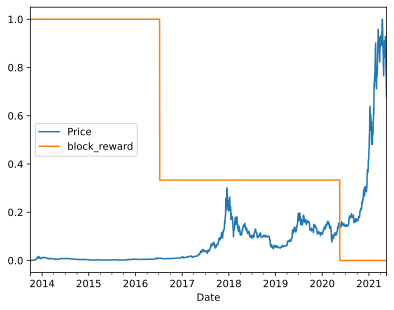

In [63]:
# plotting the block_reward, price vs time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]), columns=bitcoin_prices_block.columns,index=bitcoin_prices_block.index)

scaled_price_block_df.plot();

**Note:** We can observe, as the block_reward goes down, the bitcoin prices go up. Whether there is a correlation or not we don't know.

**24. Making a windowed dataset using Pandas**

* We can use the `pd.Dataframe.shift()` method to window our multivariate data

* We want to create a way to window our dataset directly from pandas dataframe.
  ```
    [0,1,2,3,4,5,6,block_reward] - > [7]
    [1,2,3,4,5,6,7,block_reward] - > [8]
    [2,3,4,5,6,7,8,block_reward] - > [9]
    ...
  ```

In [64]:
# set up dataset hyperparams
HORIZON = 1
WINDOW_SIZE = 7

# making a copy for windowing
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in window size
    bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654990,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,25,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,25,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,25,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


In [65]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [66]:
# create x - windows, and y - horizon features
X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [67]:
X.columns

Index(['block_reward', 'Price+1', 'Price+2', 'Price+3', 'Price+4', 'Price+5',
       'Price+6', 'Price+7'],
      dtype='object')

In [68]:
# re-ordering the columns:
cols = X.columns.tolist()
reordered_cols = cols[1:][::-1] + [cols[0]]  # Reverse Price columns and keep block_reward last
X = X[reordered_cols]

In [69]:
X

,Price+7,Price+6,Price+5,Price+4,Price+3,Price+2,Price+1,block_reward
Date,,,,,,,,
2013-10-08,123.654991,125.455002,108.584831,118.674660,121.338661,120.655327,121.794998,25.00
2013-10-09,125.455002,108.584831,118.674660,121.338661,120.655327,121.794998,123.032997,25.00
2013-10-10,108.584831,118.674660,121.338661,120.655327,121.794998,123.032997,124.049004,25.00
2013-10-11,118.674660,121.338661,120.655327,121.794998,123.032997,124.049004,125.961159,25.00
2013-10-12,121.338661,120.655327,121.794998,123.032997,124.049004,125.961159,125.279663,25.00
...,...,...,...,...,...,...,...,...
2021-05-14,56583.851562,57107.121094,58788.210938,58102.191406,55715.546875,56573.554688,52147.820312,6.25
2021-05-15,57107.121094,58788.210938,58102.191406,55715.546875,56573.554688,52147.820312,49764.132812,6.25
2021-05-16,58788.210938,58102.191406,55715.546875,56573.554688,52147.820312,49764.132812,50032.691406,6.25


In [70]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [71]:
# making train and test splits
test_size=0.2
split_size = int((1-test_size)*len(X))
X_train,y_train = X[:split_size],y[:split_size]
X_test,y_test = X[split_size:],y[split_size:] 
len(X_train),len(X_test),len(y_train),len(y_test)

(2224, 556, 2224, 556)

In [72]:
# create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name,savepath='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=f'{savepath}/{model_name}.keras',
                                              verbose = 0,
                                              monitor='val_loss',
                                              save_best_only = True
                                              )

In [73]:
# 1. model creation
inputs = tf.keras.layers.Input(shape=(8,))

# adding the dense & output layer
x = tf.keras.layers.Dense(units = 128, activation='relu')(inputs)
# x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
outputs = tf.keras.layers.Dense(units = HORIZON)(x)

model_6 = tf.keras.models.Model(inputs,outputs,name='model_6')


# 2. model compiling
model_6.compile(loss = 'mae',optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae','mse'])

# 3. getting model summary
model_6.summary()

Model: "model_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# 3. fit the model
model_6.fit(x=X_train,
            y=y_train,
            epochs = 100,
            batch_size = 128,
            validation_data = (X_test,y_test),
            verbose = 1,
            callbacks=[create_model_checkpoint(model_6.name)]
            )

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3942.2744 - mae: 3942.2744 - mse: 38997220.0000 - val_loss: 6283.5879 - val_mae: 6283.5879 - val_mse: 71809968.0000
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 593.4188 - mae: 593.4188 - mse: 1170812.2500 - val_loss: 1116.2574 - val_mae: 1116.2574 - val_mse: 4137847.7500
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 244.3848 - mae: 244.3848 - mse: 265862.9688 - val_loss: 1202.5315 - val_mae: 1202.5315 - val_mse: 4630748.0000
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 204.7265 - mae: 204.7265 - mse: 193415.9375 - val_loss: 1057.2399 - val_mae: 1057.2399 - val_mse: 3750645.7500
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 186.0993 - mae: 186.0993 - mse: 176891.8125 - val_loss: 1071.6156 - val_mae: 1071.6156 - val_mse: 3616695.2500
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 180.0689 - mae: 180.0689 - mse: 169282.9062 - val_loss: 1043.5836 - val_mae: 1043.58

In [75]:
model_6.evaluate(X_test,y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 283.3717 - mae: 283.3717 - mse: 343808.1875


[564.8431396484375, 564.8431396484375, 1159681.125]

In [80]:
# load in saved best performing model_5 and evaluate it on test data
model_6 = tf.keras.models.load_model(f'model_experiments/{model_6.name}.keras')

In [81]:
model_6.evaluate(X_test,y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 282.6539 - mae: 282.6539 - mse: 344489.0312 


[564.6026611328125, 564.6026611328125, 1159175.125]

In [82]:
# making forcasts with the model_1 on test dataset
def make_preds(model,input_data):
    '''
    Uses model to make predictions on input data
    '''

    forcast = model.predict(input_data)
    return tf.squeeze(forcast) # return 1D array of predictions

model_6_preds=make_preds(model_6,X_test)
len(model_6_preds),model_6_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8865.099, 8780.743, 9032.178, 8794.326, 8733.787, 8734.966,
        8690.912, 8527.175, 8458.682, 8530.641], dtype=float32)>)

In [83]:
model_6_results = tsf.evaluate_time_series(y_test,model_6_preds)
model_6_results

{'mae': 564.60266,
 'mse': 1159175.1,
 'rmse': 1076.6499,
 'mape': 2.5315979,
 'mase': 0.9918505}

In [84]:
#  using the dataframe of bit-coin prices
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

# WINDOWING 
HORIZON = 1
WINDOW_SIZE = 7

full_windows,full_labels = tsf.make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)

# train-test split without windowing
train_percent = 80
split_size = int(train_percent*0.01*len(timesteps))
test_series,test_prices = timesteps[split_size:],prices[split_size:]


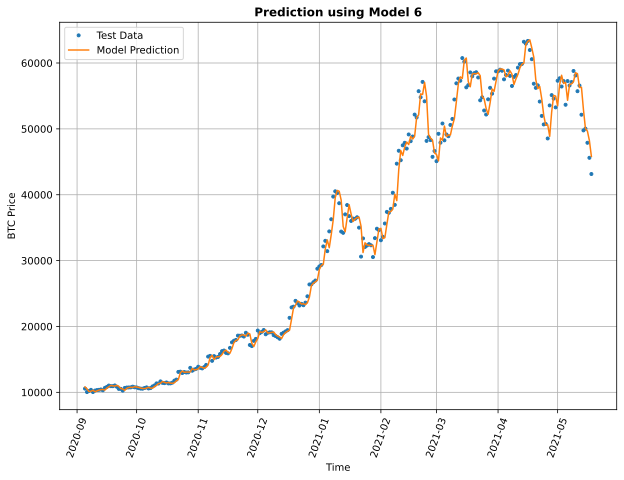

In [102]:
# plotting model_3 predictions
offset = 300
end = None
plt.figure(figsize=(10,7))

# account for test_window offset and index into test_labels to ensure correct plotting
tsf.plot_time_series(timesteps = test_series[-len(X_test):] , values = y_test.to_numpy(),start = offset,end=end,label = "Test Data",format='.')
tsf.plot_time_series(timesteps = test_series[-len(X_test):] , values = model_6_preds,start = offset,end=end,label = "Model Prediction", format='-',xtick_rotation=70,ylabel='BTC Price')
plt.title("Prediction using Model 6",fontsize = 12, fontweight='bold')
plt.show()

***-- CONTD IN NEXT NOTEBOOK --***